### 导入库

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
plt.rcParamsl['font.sans-serif'] = ['SimHei']  # 步骤一（替换sans-serif字体）
plt.rcParams['axes.unicode_minus'] = False   # 步骤二（解决坐标轴负数的负号显示问题）
import json
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import models, transforms

from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method  
from cleverhans.torch.attacks.carlini_wagner_l2 import carlini_wagner_l2
from cleverhans.torch.attacks.projected_gradient_descent import projected_gradient_descent



### 对抗样本生成函数

In [5]:

def attack(victim_model, img,attack_type, eps,eps_iter,nb_iter, norm=np.inf,clip_min=None,
    clip_max=None,
    y=None,
    targeted=False,
    rand_init=True,
    rand_minmax=None,
    sanity_checks=True,):
        """
        使用攻击算法得到对抗样本

        :param img: 输入的合法legitimate数据
        :return: 输入数据对应的对抗样本
        """
        if attack_type == "FGSM":
            from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method  
            img = fast_gradient_method(victim_model, img, eps, np.inf)
        elif attack_type == "PGD":
            from cleverhans.torch.attacks.projected_gradient_descent import projected_gradient_descent
            img = projected_gradient_descent(victim_model, img,
                                             eps=eps, eps_iter=eps_iter,
                                             nb_iter=nb_iter, norm=np.inf)
        elif attack_type == "CW":
            img = carlini_wagner_l2(victim_model, img, n_classes=500,
                                      lr=0.01,
                                      initial_const=0.01,
                                      binary_search_steps=9,
                                      max_iterations=1000)
        else:
            raise RuntimeError("Attack type is invalid!")
        return img

### 计算均方误差的函数

In [6]:

def MSE(img1,img2):
    mse = np.mean( (img1 - img2) ** 2 )
    return mse

## 自定义BIM

### 对生成的扰动进行筛选，裁剪

In [ ]:
def clip_eta(eta, norm, eps):
    """
    PyTorch implementation of the clip_eta in utils_tf.
    进行扰动筛选，比如L1,L2,L0范数约束下

    :param eta: Tensor
    :param norm: np.inf, 1, or 2
    :param eps: float
    """
    if norm not in [np.inf, 1, 2]:
        raise ValueError("norm must be np.inf, 1, or 2.")

    avoid_zero_div = torch.tensor(1e-12, dtype=eta.dtype, device=eta.device)
    reduc_ind = list(range(1, len(eta.size())))
    if norm == np.inf:
        eta = torch.clamp(eta, -eps, eps)
    else:
        if norm == 1:
            raise NotImplementedError("L1 clip is not implemented.")
            norm = torch.max(
                avoid_zero_div, torch.sum(torch.abs(eta), dim=reduc_ind, keepdim=True)
            )
        elif norm == 2:
            norm = torch.sqrt(
                torch.max(
                    avoid_zero_div, torch.sum(eta ** 2, dim=reduc_ind, keepdim=True)
                )
            )
        factor = torch.min(
            torch.tensor(1.0, dtype=eta.dtype, device=eta.device), eps / norm
        )
        eta *= factor
    return eta


### 主函数

In [ ]:
def BIM(victim_model, img, eps, eps_iter, nb_iter, norm=np.inf, clip_min=None,
    clip_max=None,
    y=None,
    targeted=False,
    rand_init=True,
    rand_minmax=None,
    sanity_checks=True,):
        """
        传入(1,3,224,224)的图片，返回对抗样本
        """
        ori_x=img
        adv_x = img
        from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
        i = 0
        while i < nb_iter:
            adv_x,eta = fast_gradient_method(
                victim_model,
                adv_x,
                eps_iter,
                norm,
                clip_min=clip_min,
                clip_max=clip_max,
                y=y,
                targeted=targeted,
            )

            # Clipping perturbation eta to norm norm ball
            
            eta = clip_eta(eta, norm, eps)
            adv_x = ori_x + eta


        i += 1
        return adv_x,eta

In [1]:

# 1.下载并加载预训练模型
model = models.resnet18(pretrained=True)
model = model.eval()

# 2.加载标签并对输入数据进行处理
labels_path = './imagenet_class_index.json'
with open(labels_path) as json_data:
    idx2labels = json.load(json_data)
    
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# 3.使用模型进行预测
def preimg(img):
    if img.mode == 'RGBA':
        ch = 4
        a = np.asarray(img)[:, :, :3]
        img = Image.fromarray(a)
    return img


im = preimg(Image.open('panda.jpg'))
transformed_img = transform(im)

inputimg = transformed_img.unsqueeze(0)
adv_img,p = attack(model, inputimg, "FGSM", eps=0.2, eps_iter=0.01, nb_iter=10)

output = model(inputimg)
output = F.softmax(output, dim=1)
output_adv = model(adv_img)
output_adv = F.softmax(output_adv, dim=1)

# 4.输出预测结果
# 对抗样本结果
print("下面为对抗样本结果")
score_adv, id_adv = torch.topk(output_adv, 3)
score_adv = score_adv.detach().numpy()[0]
print(score_adv[0])

id_adv = id_adv.detach().numpy()[0]
print(id_adv)

label_adv = idx2labels[str(id_adv[0])][1]
print(label_adv)

# 原始样本结果
print("下面为原始样本结果")
prediction_score, pred_label_idx = torch.topk(output, 3)
prediction_score = prediction_score.detach().numpy()[0]
print(prediction_score[0])

pred_label_idx = pred_label_idx.detach().numpy()[0]
print(pred_label_idx)

predicted_label = idx2labels[str(pred_label_idx[0])][1]
print(predicted_label)


# 反标准化
unnormalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

# 复原对抗样本
adv_im = unnormalize(adv_img[0])
adv_im = adv_im.permute(1, 2, 0).detach().numpy()

# 将值限制在0-1之间(这样会使攻击性减弱，影响对抗样本效果)
adv_im = np.clip(adv_im, 0, 1)
# 保存图片
#plt.imsave('adv_panda.jpg', adv_im)

# 复原原始样本
input_im = unnormalize(inputimg[0])
input_im = input_im.permute(1, 2, 0).detach().numpy()






NameError: name 'models' is not defined

### 计算均分误差

In [25]:
MSE(input_im,adv_im)

0.00034143138

## 结果可视化

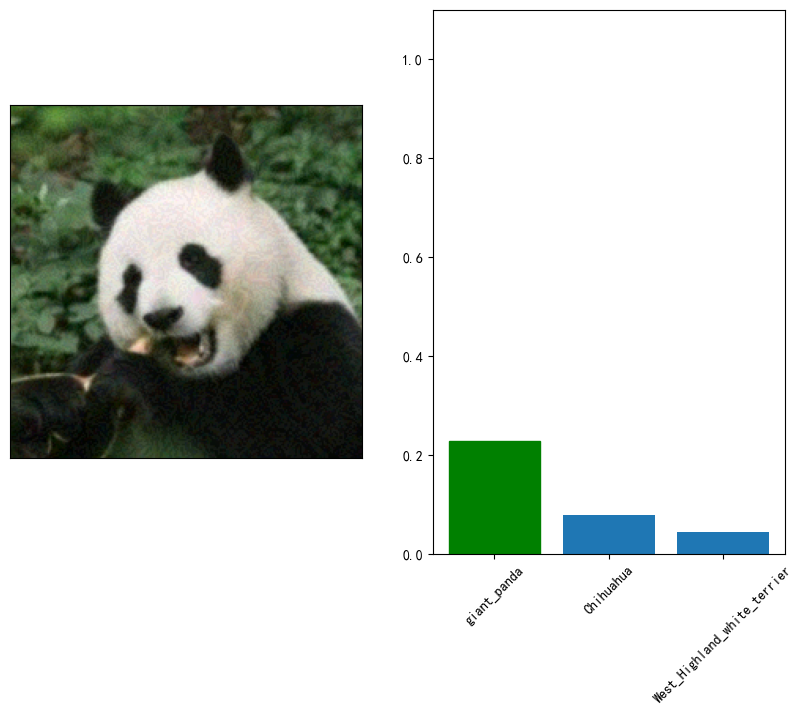

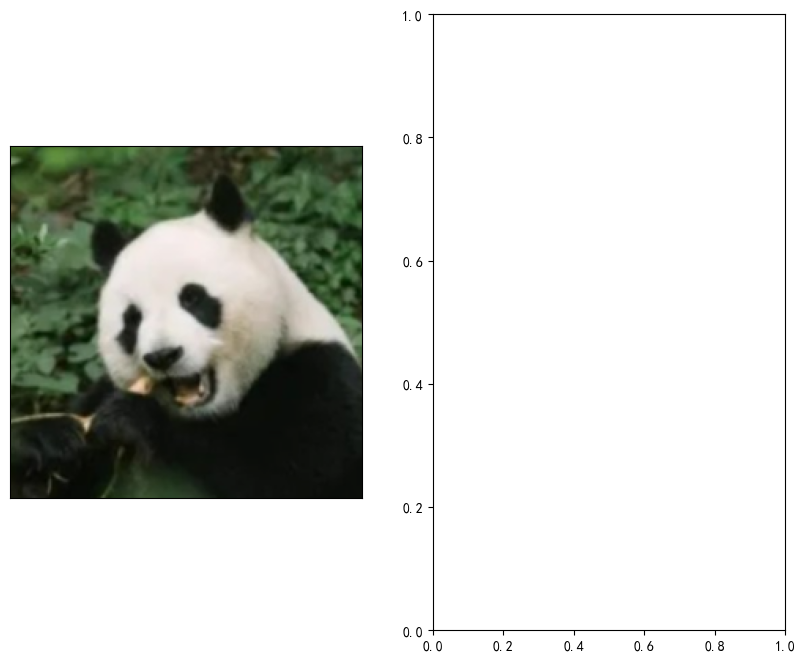

In [5]:

# 4.预测结果可视化
# 对抗样本可视化
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
fig.sca(ax1)
ax1.imshow(adv_im)
plt.xticks([])
plt.yticks([])

barlist = ax2.bar(range(3), [i for i in score_adv])
barlist[0].set_color('g')

plt.sca(ax2)
plt.ylim([0, 1.1])

plt.xticks(range(3),
           [idx2labels[str(i)][1] for i in id_adv],
           rotation=45)
fig.subplots_adjust(bottom=0.2)
plt.show()

# 原始样本可视化
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
fig.sca(ax1)
ax1.imshow(input_im)
plt.xticks([])
plt.yticks([])
plt.show()


In [ ]:
class PGD:
    def __init__(self, model, eps=1., alpha=0.3):
        self.model = (
            model.module if hasattr(model, "module") else model
        )
        self.eps = eps
        self.alpha = alpha
        self.emb_backup = {}
        self.grad_backup = {}
 
    def attack(self, emb_name='word_embeddings', is_first_attack=False):
        for name, param in self.model.named_parameters():
            if param.requires_grad and emb_name in name:
                if is_first_attack:
                    self.emb_backup[name] = param.data.clone()
                norm = torch.norm(param.grad)
                if norm != 0 and not torch.isnan(norm):
                    r_at = self.alpha * param.grad / norm
                    param.data.add_(r_at)
                    param.data = self.project(name, param.data)
 
    def restore(self, emb_name='word_embeddings'):
        for name, param in self.model.named_parameters():
            if param.requires_grad and emb_name in name:
                assert name in self.emb_backup
                param.data = self.emb_backup[name]
        self.emb_backup = {}
 
    def project(self, param_name, param_data):
        r = param_data - self.emb_backup[param_name]
        if torch.norm(r) > self.eps:
            r = self.eps * r / torch.norm(r)
        return self.emb_backup[param_name] + r
 
    def backup_grad(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad and param.grad is not None:
                self.grad_backup[name] = param.grad.clone()
 
    def restore_grad(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad and param.grad is not None:
                param.grad = self.grad_backup[name]

### 加载标签

In [ ]:
labels_path = './imagenet_class_index.json'
with open(labels_path) as json_data:
    idx2labels = json.load(json_data)

In [13]:

model = models.resnet18(pretrained=True)
model = model.eval()
im = Image.open('panda.jpg')
#变为tensor
transform = transforms.Compose([
      transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
transformed_img = transform(im)
inputimg = transformed_img.unsqueeze(0)
print(inputimg.shape)

def attack(victim_model, img,attack_type, eps=0.1, lr=0.01, initial_const=0.01, binary_search_steps=9, max_iterations=1000):
        """
        使用攻击算法得到对抗样本

        :param img: 输入的合法legitimate数据
        :return: 输入数据对应的对抗样本
        """
        if attack_type == "FGSM":
            from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method  
            img = fast_gradient_method(victim_model, img, eps, np.inf)
        elif attack_type == "PGD":
            from cleverhans.torch.attacks.projected_gradient_descent import projected_gradient_descent
            img = projected_gradient_descent(victim_model, img,
                                             eps=eps, eps_iter=0.01,
                                             nb_iter=40, norm=np.inf)
        elif attack_type == "CW":
            img = carlini_wagner_l2(victim_model, img, n_classes=500,
                                      lr=lr,
                                      initial_const=initial_const,
                                      binary_search_steps=binary_search_steps,
                                      max_iterations=max_iterations)
        else:
            raise RuntimeError("Attack type is invalid!")
        return img
ans = attack(model, inputimg,"FGSM")
output = model(ans)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 3)
prediction_score = prediction_score.detach().numpy()[0]
print(prediction_score[0])
pred_label_idx = pred_label_idx.detach().numpy()[0]
print(pred_label_idx)

predicted_label = idx2labels[str(pred_label_idx[0])][1]
print(predicted_label)
print(output)
# print(ans.shape)
# ans = ans.detach().numpy()
# print(ans.shape)
# arr = ans.transpose((1, 2, 3, 0))
# arr = arr.squeeze()
# print(arr.shape)
# print(arr)
# anti_im=Image.fromarray(arr)
# anti_im.save('anti_panda.jpg')

torch.Size([1, 3, 224, 224])
0.22777063
[388 151 203]
giant_panda
tensor([[6.5450e-04, 3.4347e-04, 4.6348e-05, 1.0281e-05, 3.9253e-05, 4.0218e-04,
         1.3328e-04, 5.3119e-05, 3.5285e-04, 7.8545e-06, 6.3007e-06, 1.0749e-04,
         1.5264e-05, 4.5523e-05, 2.4973e-05, 2.6549e-05, 1.8191e-04, 4.6882e-04,
         2.5024e-04, 5.8786e-04, 3.1133e-05, 8.6678e-05, 8.7378e-06, 4.3211e-04,
         1.5711e-04, 3.5643e-04, 1.5367e-04, 5.8029e-05, 5.5783e-05, 4.1301e-03,
         7.8507e-05, 1.0108e-03, 2.5859e-04, 2.9818e-04, 3.2528e-04, 2.0038e-04,
         1.2039e-03, 1.5264e-04, 4.4514e-05, 4.4613e-05, 1.4863e-04, 4.3460e-05,
         1.0310e-04, 9.2527e-06, 1.9093e-05, 1.4069e-04, 2.1279e-04, 4.7081e-04,
         2.8084e-04, 1.1897e-05, 4.6448e-05, 9.7496e-05, 1.3659e-04, 1.8510e-04,
         9.8433e-05, 1.1574e-04, 1.6504e-04, 7.5283e-06, 3.5617e-05, 5.0247e-05,
         1.1450e-04, 1.6572e-04, 3.1608e-05, 3.2984e-05, 2.6921e-05, 4.0394e-05,
         4.7493e-05, 4.6924e-05, 2.5678e-05